In [1]:
import pwmsim

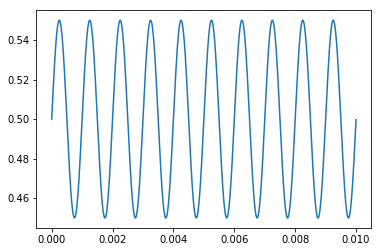

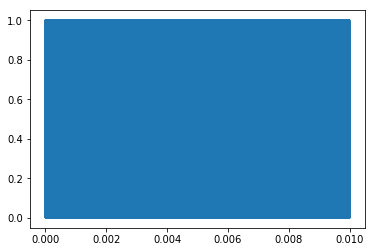

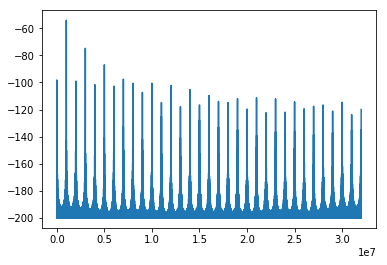

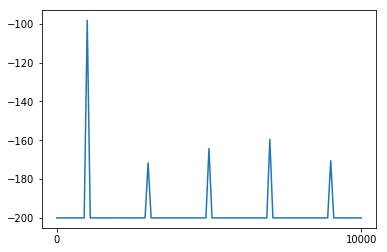

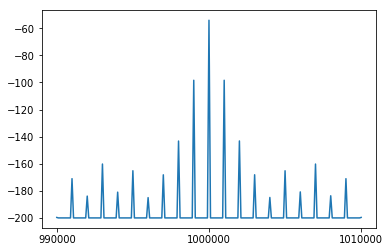

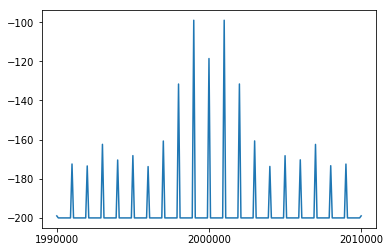

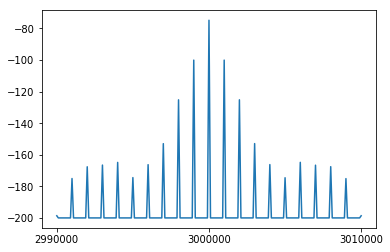

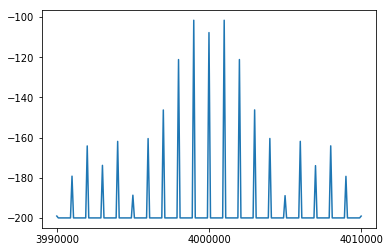

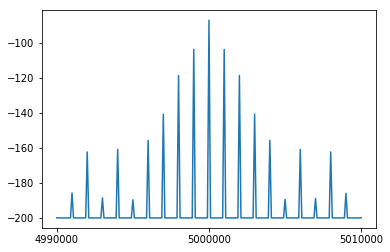

In [2]:
pwmsim.main(notebook=True)